# Предсказание цен в Airbnb
Скриншоты карт можно посмотреть в папке "plots/airbnb"
для просмотра карт нужно: pip3 install ipyleaflet


In [1]:
from math import sqrt
import pandas as pd
import seaborn as sns
from ipyleaflet import *
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures



from sklearn import preprocessing
from scipy.spatial import distance


In [2]:
data_file = "../csv/airbnb/air_bnb.csv"
dataset = pd.read_csv(data_file)
for feature in "id, name, host_id, host_name, last_review".split(", "):
    dataset.drop(feature,inplace=True, axis=1)
dataset.describe(percentiles=[0.003, 0.997])

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
0.3%,40.578891,-74.097682,25.000000,1.000000,0.000000,0.020000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
99.7%,40.881831,-73.745164,1500.000000,120.000000,292.000000,9.410000,327.000000,365.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [3]:
dataset.sort_values(by='price',ascending=False).head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
9151,Queens,Astoria,40.76810,-73.91651,Private room,10000,100,2,0.04,1,0
17692,Brooklyn,Greenpoint,40.73260,-73.95739,Entire home/apt,10000,5,5,0.16,1,0
29238,Manhattan,Upper West Side,40.77213,-73.98665,Entire home/apt,10000,30,0,NaN,1,83
40433,Manhattan,Lower East Side,40.71980,-73.98566,Entire home/apt,9999,30,0,NaN,1,365
12342,Manhattan,Lower East Side,40.71355,-73.98507,Private room,9999,99,6,0.14,1,83


## Посмотрим в каких колонках есть пропуски

In [4]:
dataset.isna().any()

neighbourhood_group               False
neighbourhood                     False
latitude                          False
longitude                         False
room_type                         False
price                             False
minimum_nights                    False
number_of_reviews                 False
reviews_per_month                  True
calculated_host_listings_count    False
availability_365                  False
dtype: bool

## Заполним пропуски нулями

In [5]:
dataset['reviews_per_month'].fillna(0,inplace=True)

In [6]:
dataset.isna().any()

neighbourhood_group               False
neighbourhood                     False
latitude                          False
longitude                         False
room_type                         False
price                             False
minimum_nights                    False
number_of_reviews                 False
reviews_per_month                 False
calculated_host_listings_count    False
availability_365                  False
dtype: bool

<AxesSubplot:ylabel='Frequency'>

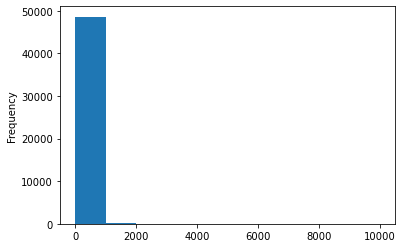

In [7]:
dataset['price'].plot.hist()

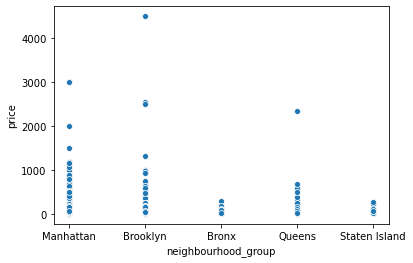

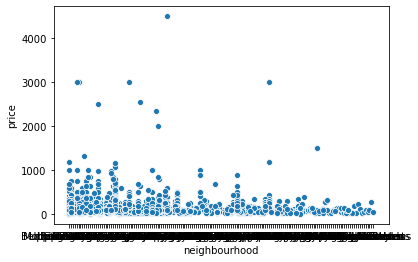

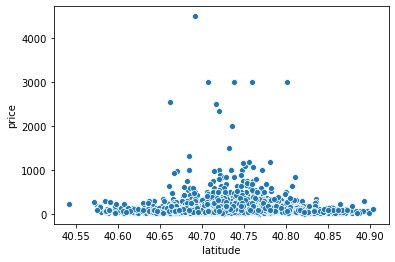

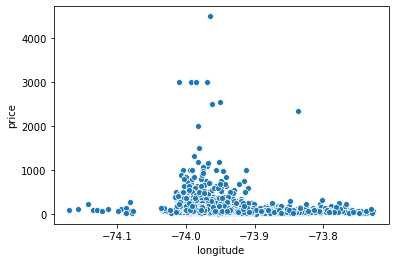

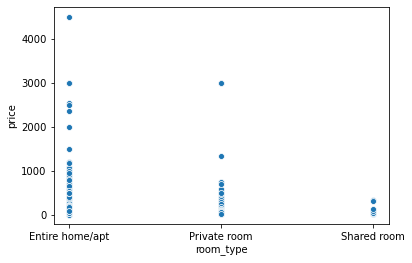

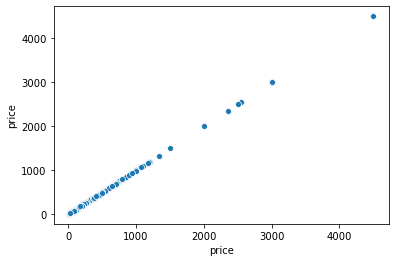

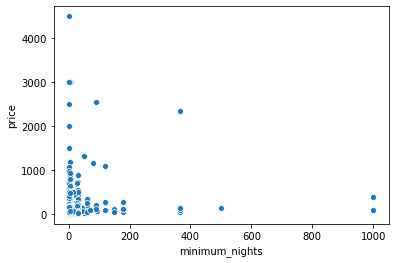

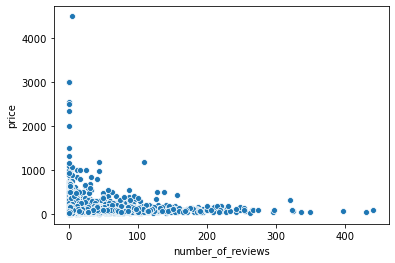

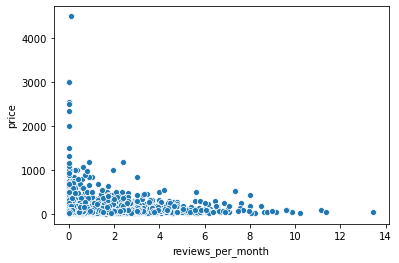

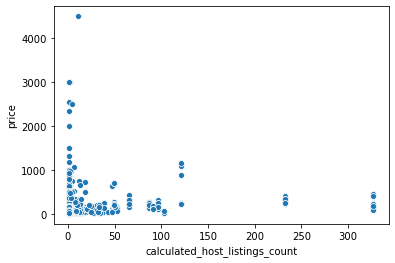

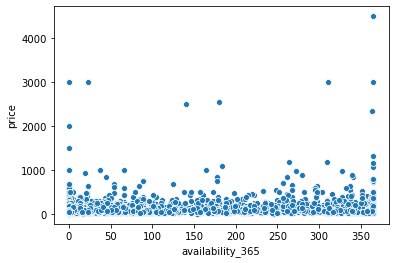

In [8]:
sample = dataset.sample(3000)
for feature in sample.columns:
    sns.scatterplot(x=sample[feature], y = sample['price'])
    plt.show()

## Попробуем откинуть верхние и нижние 5%

In [9]:
dataset.drop(dataset[dataset['price'] > 1500.0].index, inplace=True)
dataset.drop(dataset[dataset['price'] < 25.0].index, inplace=True)


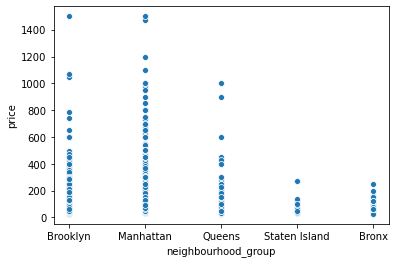

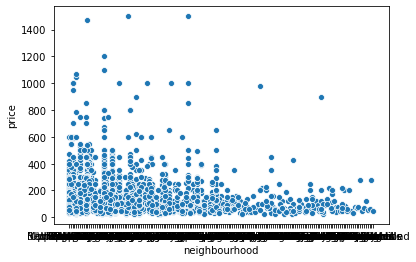

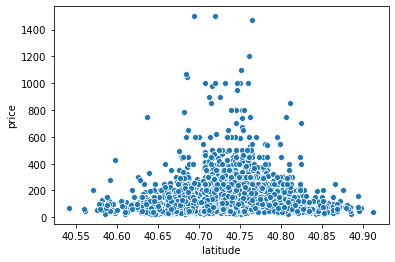

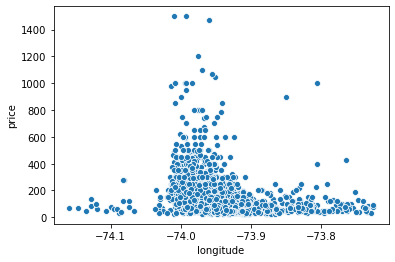

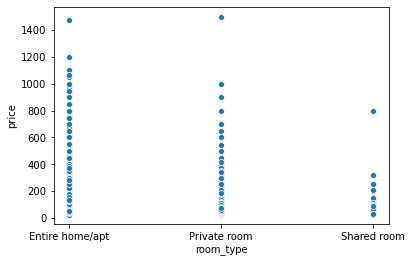

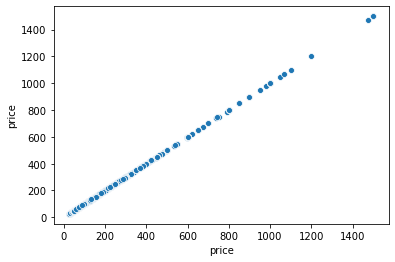

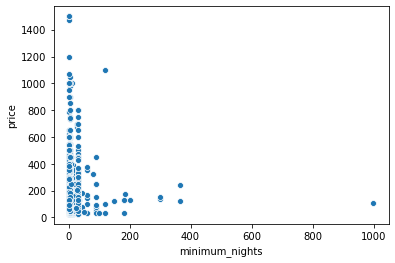

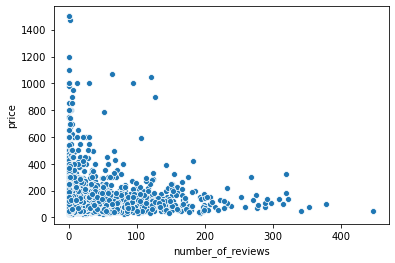

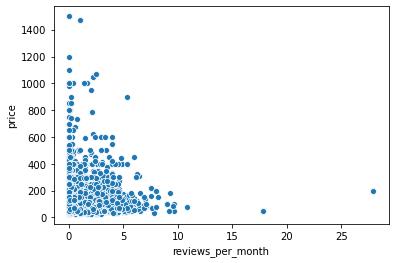

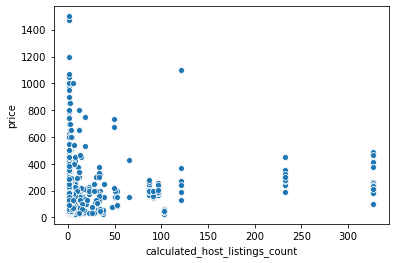

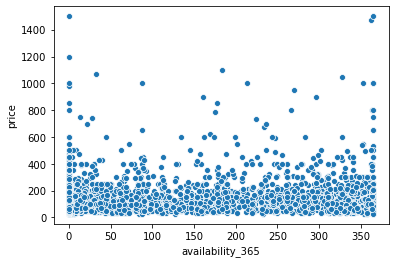

In [10]:
sample = dataset.sample(3000)
for feature in sample.columns:
    sns.scatterplot(x=sample[feature], y = sample['price'])
    plt.show()

<AxesSubplot:ylabel='Frequency'>

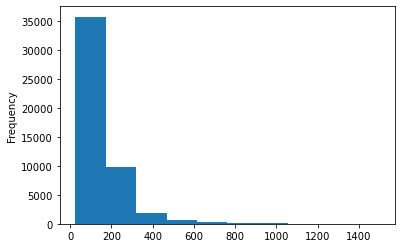

In [11]:
dataset['price'].plot.hist()

##  Посмотрим где расположены самые дорогие аппартаменты

In [24]:
a = Map(center=(40.7072,-73.9909), zoom = 10)
mean_price = dataset['price'].mean()
for index, row in dataset.iterrows():
    if row['price'] >= 1500:
        a.add_layer(Marker(location=(row['latitude'], row['longitude']),draggable=False))
a

Map(center=[40.7072, -73.9909], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

##  Посмотрим где расположены самые дешевые аппартаменты

In [25]:
a = Map(center=(40.7072,-73.9909), zoom = 10)
mean_price = dataset['price'].mean()
for index, row in dataset.iterrows():
    if row['price'] <= 25:
        a.add_layer(Marker(location=(row['latitude'], row['longitude']),draggable=False))
a

Map(center=[40.7072, -73.9909], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

##  Видно что много дорого жилья расположенно на манхэттане, а дешевого жилья там нет

##  Построим Heatmap

In [13]:
a = Map(center=(40.7072,-73.9909), zoom = 10)
markers = []
heat_coef = 1/100

for index, row in dataset.iterrows():
    markers.append([row['latitude'], row['longitude'], row['price'] * heat_coef]) 
heatmap = Heatmap(locations=markers, radius=10)
a.add_layer(heatmap)
a

Map(center=[40.7072, -73.9909], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

## А теперь посмотрим где расположены  5% самых дорогих аппартамментов

In [15]:
dataset.describe(percentiles=[0.95,0.05])

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,46050.000000,46050.000000,46050.000000,46050.000000,46050.000000,46050.000000,46050.00000,46050.000000
mean,40.728674,-73.951207,123.451531,6.933920,23.887970,1.104862,6.70317,109.664017
std,0.054944,0.046207,71.698972,19.874165,45.271781,1.610611,31.24684,130.376280
min,40.499790,-74.244420,30.000000,1.000000,0.000000,0.000000,1.00000,0.000000
5%,40.645800,-74.003250,40.000000,1.000000,0.000000,0.000000,1.00000,0.000000
50%,40.722110,-73.954730,100.000000,2.000000,5.000000,0.380000,1.00000,40.000000
95%,40.826085,-73.864253,275.000000,30.000000,116.000000,4.350000,13.00000,358.000000
max,40.913060,-73.712990,355.000000,1250.000000,629.000000,58.500000,327.00000,365.000000


In [16]:
a = Map(center=(40.7072,-73.9909), zoom = 10)

markers = []
heat_coef = 1/100
percentile_95_price = 275.0

for index, row in dataset.iterrows():
    if row['price'] < percentile_95_price:
        continue
    markers.append([row['latitude'], row['longitude'], row['price'] * heat_coef]) 
heatmap = Heatmap(locations=markers, radius=10)
a.add_layer(heatmap)
a

Map(center=[40.7072, -73.9909], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

## Видно, что скопление дорогих аппартаментов находится на юге Central Park, около Financial District и на западном берегу между этими районами. Возьмем точку посередине и будет от нее отсчитывать расстояние.

In [14]:
cent_lon = 40.733321
cent_lat = -74.000489
cent = (cent_lon, cent_lat)
dataset['relative_dist'] = np.array(list(distance.euclidean(cent, (row['longitude'],row['latitude'])) 
                                    for index, row in dataset.iterrows()))

In [15]:
dataset.sort_values(by='relative_dist',ascending=False).head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,relative_dist
23011,Bronx,North Riverdale,40.91169,-73.90564,Private room,50,365,0,0.00,1,363,162.317283
25308,Bronx,North Riverdale,40.90734,-73.90137,Private room,119,3,0,0.00,1,0,162.311187
3349,Bronx,North Riverdale,40.90804,-73.90005,Private room,53,2,143,2.13,1,263,162.310751
48033,Bronx,North Riverdale,40.91167,-73.89566,Private room,40,1,1,1.00,3,174,162.310220
14715,Bronx,Riverdale,40.90080,-73.90639,Private room,49,6,2,0.05,1,340,162.310103


## Попробуем построить простую линейную регрессию, преобразовав строковые значения в булевы(dummies)

In [28]:
dummies = pd.get_dummies(data=dataset, columns=['room_type', 'neighbourhood', 'neighbourhood_group'])

In [29]:
y = dummies['price']
dummies.drop(columns=['price', 'latitude', 'longitude'], inplace=True)
dummies.describe()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,relative_dist,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_Allerton,...,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island
count,48627.000000,48627.000000,48627.000000,48627.000000,48627.000000,48627.000000,48627.000000,48627.000000,48627.000000,48627.000000,...,48627.000000,48627.000000,48627.000000,48627.000000,48627.000000,48627.000000,48627.000000,48627.000000,48627.000000,48627.000000
mean,6.980587,23.351903,1.093589,7.164806,112.610093,162.220871,0.519855,0.457503,0.022642,0.000864,...,0.003229,0.001789,0.000226,0.000021,0.004833,0.022128,0.411418,0.443005,0.115882,0.007568
std,20.305573,44.635188,1.598480,33.037818,131.516980,0.048344,0.499611,0.498196,0.148760,0.029377,...,0.056730,0.042261,0.015039,0.004535,0.069350,0.147100,0.492096,0.496746,0.320087,0.086664
min,1.000000,0.000000,0.000000,1.000000,0.000000,161.974881,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.040000,1.000000,0.000000,162.187634,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,5.000000,0.370000,1.000000,45.000000,162.224497,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,24.000000,1.590000,2.000000,226.000000,162.258670,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1250.000000,629.000000,58.500000,327.000000,365.000000,162.317283,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
X_train, X_test, y_train, y_test = train_test_split(dummies, y, test_size=0.33,
                                                        random_state=42)

scaler = StandardScaler()
reg = LinearRegression()
pipe = Pipeline([('scaler', scaler), ('reg', reg)])
pipe.fit(X_train, y_train)
print("Линейная регрессия:")
print("\tПравильность на обучающем наборе: {:.2f}".format(pipe.score(X_train, y_train)))
print("\tПравильность на тестовом наборе: {:.2f}".format(pipe.score(X_test, y_test)))

ridge = RidgeCV(alphas=[0.01,0.1, 0.3, 0.5, 0.7, 1, 2, 5, 10, 50, 100, 1000])
pipe = Pipeline([('scaler', scaler), ('reg', ridge)])
pipe.fit(X_train, y_train)
print("Гребневая регрессия:")
print("\tПравильность на обучающем наборе: {:.2f}".format(pipe.score(X_train, y_train)))
print("\tПравильность на тестовом наборе: {:.2f}".format(pipe.score(X_test, y_test)))

lasso = LassoCV(cv = 5, alphas=[0.01,0.1, 0.3, 0.5, 0.7], max_iter=10000)
pipe = Pipeline([('scaler', scaler), ('reg', lasso)])
pipe.fit(X_train, y_train)
print("Лассо:")
print("\tПравильность на обучающем наборе: {:.2f}".format(pipe.score(X_train, y_train)))
print("\tПравильность на тестовом наборе: {:.2f}".format(pipe.score(X_test, y_test)))

el = ElasticNetCV(alphas=[0.01, 0.1, 0.2, 0.5, 0.7, 0.9])
pipe = Pipeline([('scaler', scaler), ('reg', el)])
pipe.fit(X_train, y_train)
print("ElasticNet:")
print("\tПравильность на обучающем наборе: {:.2f}".format(pipe.score(X_train, y_train)))
print("\tПравильность на тестовом наборе: {:.2f}".format(pipe.score(X_test, y_test)))

Линейная регрессия:
	Правильность на обучающем наборе: 0.33
	Правильность на тестовом наборе: -3295143994855987871744.00
Гребневая регрессия:
	Правильность на обучающем наборе: 0.32
	Правильность на тестовом наборе: 0.31
Лассо:
	Правильность на обучающем наборе: 0.32
	Правильность на тестовом наборе: 0.31
ElasticNet:
	Правильность на обучающем наборе: 0.32
	Правильность на тестовом наборе: 0.31


## Видно, что линейная регрессия в данном случаем плохо работает

Всего параметров: 233


(array([  1.,   0.,   3.,   5., 188.,  32.,   1.,   1.,   0.,   2.]),
 array([-17.54694075, -13.81518346, -10.08342617,  -6.35166888,
         -2.61991159,   1.11184569,   4.84360298,   8.57536027,
         12.30711756,  16.03887485,  19.77063214]),
 <BarContainer object of 10 artists>)

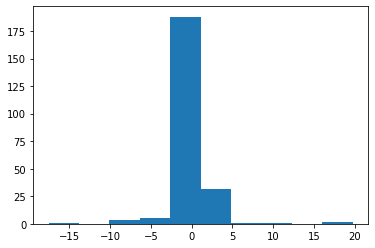

In [22]:
print("Всего параметров: {0}".format(len(ridge.coef_)))
plt.hist(ridge.coef_)

## Видно что почти все параметры занулились, кроме штук 5-10 из 235. В папке plots/airbnb есть график coef_by_features, из него ясно что не занулились: relative_dist, longitude, latitude, room_type (private и entire_home, а вот shared_room почти 0)

In [23]:
dataset.columns

Index(['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'relative_dist'],
      dtype='object')

In [27]:
columns_to_drop = [ 'neighbourhood','neighbourhood_group',
        'price']
ds = pd.get_dummies(data=dataset, columns=['room_type'])
ds.drop(ds[ds['price'] > 1500.0].index, inplace=True)
y = ds['price']

X_train, X_test, y_train, y_test = train_test_split(ds.drop(columns=columns_to_drop), y, test_size=0.33,
                                                        random_state=42)

poly = PolynomialFeatures(3)
scaler = StandardScaler()
lr = LinearRegression()
pipe = Pipeline([
    ('poly', poly),
    ('scaler', scaler), 
    ('reg', lr)])
pipe.fit(X_train, y_train)
print("Линейная регрессия:")
print("\tПравильность на обучающем наборе: {:.2f}".format(pipe.score(X_train, y_train)))
print("\tПравильность на тестовом наборе: {:.2f}".format(pipe.score(X_test, y_test)))

ridge = RidgeCV(alphas=[0.01,0.1, 0.3, 0.5, 0.7, 1])
pipe = Pipeline([
    ('poly', poly),
    ('scaler', scaler), 
    ('reg', lr)])
pipe.fit(X_train, y_train)
print("Гребневая регрессия:")
print("\tПравильность на обучающем наборе: {:.2f}".format(pipe.score(X_train, y_train)))
print("\tПравильность на тестовом наборе: {:.2f}".format(pipe.score(X_test, y_test)))

lasso = LassoCV(cv = 5, alphas=[0.01,0.1, 0.3])
pipe = Pipeline([
    ('poly', poly),
    ('scaler', scaler), 
    ('reg', lr)])
pipe.fit(X_train, y_train)
print("Лассо:")
print("\tПравильность на обучающем наборе: {:.2f}".format(pipe.score(X_train, y_train)))
print("\tПравильность на тестовом наборе: {:.2f}".format(pipe.score(X_test, y_test)))

el = ElasticNetCV(alphas=[0.01, 0.1, 0.2, 0.5, 0.7, 0.9])
pipe = Pipeline([('poly', poly),
    ('scaler', scaler), 
    ('reg', lr)])
pipe.fit(X_train, y_train)
print("ElasticNet:")
print("\tПравильность на обучающем наборе: {:.2f}".format(pipe.score(X_train, y_train)))
print("\tПравильность на тестовом наборе: {:.2f}".format(pipe.score(X_test, y_test)))

Линейная регрессия:
	Правильность на обучающем наборе: 0.35
	Правильность на тестовом наборе: 0.33
Гребневая регрессия:
	Правильность на обучающем наборе: 0.35
	Правильность на тестовом наборе: 0.33
Лассо:
	Правильность на обучающем наборе: 0.35
	Правильность на тестовом наборе: 0.33
ElasticNet:
	Правильность на обучающем наборе: 0.35
	Правильность на тестовом наборе: 0.33
